In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
sys.path.append('../experiments')
import dvu
import seaborn as sns
import os
import pandas as pd
from copy import deepcopy
from matplotlib import pyplot as plt
from os.path import join
import numpy as np
import ast
import json
import imodelsx.process_results
import neuro.features.qa_questions as qa_questions
import joblib
from tqdm import tqdm
from neuro import analyze_helper, viz
from transformers import AutoModelForTokenClassification, AutoTokenizer
import torch
import neuro.config
import spacy
fit_encoding = __import__('02_fit_encoding')
dvu.set_style()
nlp = spacy.load("en_core_web_sm")
device = torch.device("cuda:0")
path = f"KomeijiForce/Cuckoo-C4-Super-Rainbow"
tokenizer = AutoTokenizer.from_pretrained(path)
tagger = AutoModelForTokenClassification.from_pretrained(path).to(device)

In [4]:
def next_tokens_extraction(text):
    def _find_sequences(tag_predictions, refine_tag_predictions=False):
        sequences = []
        i = 0
        while i < len(tag_predictions):
            # 0 is the "Begin" tag
            if tag_predictions[i] == 0:
                start = i
                end = i
                i += 1

                # 1 is the "Inside" tag
                while i < len(tag_predictions) and tag_predictions[i] == 1:
                    end = i
                    i += 1

                sequences.append((start, end+1))
            else:
                i += 1
        return sequences

    text = " ".join([token.text for token in nlp(text)])
    tokens = tokenizer.tokenize(text)
    # print(tokens)

    inputs = tokenizer(text, return_tensors="pt").to(device)
    tag_predictions = tagger(**inputs).logits[0].argmax(-1).cpu().numpy()

    # only keep relevant tokens
    start_idx = tokens.index('ĊĊ')
    end_idx = tokens.index('ĠQuestion') - 2
    # print(start_idx)
    input_ids = inputs.input_ids[0, start_idx:end_idx]
    tag_predictions = tag_predictions[start_idx:end_idx]
    tokens = tokens[start_idx: end_idx]

    predictions = [tokenizer.decode(input_ids[seq[0]:seq[1]]).strip(
    ) for seq in _find_sequences(tag_predictions)]

    tokens = tokens[:-1]
    tag_predictions = tag_predictions[1:]

    return tokens, tag_predictions, predictions


def clean_token(s):
    return s.replace('Ċ', '_').replace('Ġ', '_')

### Basic example

What is the person mentioned here? ['Tom', 'Jack']
What is the city mentioned here? ['Paris', 'London']
Who goes with Tom together? ['Jack']
What do Tom and Jack go to Paris for? ['their trip']
Where does George live in? ['London']


<Axes: >

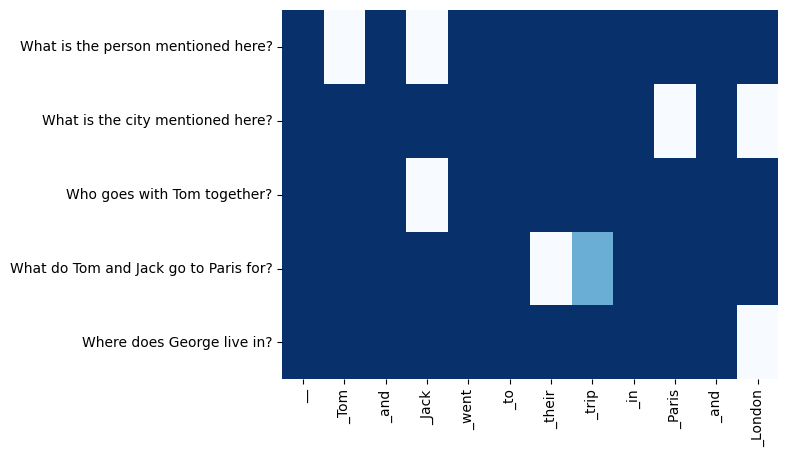

In [5]:
text = "Tom and Jack went to their trip in Paris and London."

tag_predictions_list = []
questions = [
    "What is the person mentioned here?",
    "What is the city mentioned here?",
    "Who goes with Tom together?",
    "What do Tom and Jack go to Paris for?",
    "Where does George live in?",
]
for question in questions:
    prompt = f"User:\n\n{text}\n\nQuestion: {question}\n\nAssistant:"
    tokens, tag_predictions, predictions = next_tokens_extraction(prompt)
    tokens = [clean_token(token) for token in tokens]
    print(question, predictions)
    tag_predictions_list.append(tag_predictions)


df = pd.DataFrame(tag_predictions_list, columns=tokens, index=questions)
sns.heatmap(df, cmap="Blues", cbar=False)

### MDCalc example

In [6]:
# download medcalc dataset
# wget https://raw.githubusercontent.com/ncbi-nlp/MedCalc-Bench/refs/heads/main/dataset/test_data.csv
df_mdcalc = pd.read_csv('test_data.csv')

In [7]:
row = df_mdcalc[df_mdcalc['Calculator Name'] ==
                'CHA2DS2-VASc Score for Atrial Fibrillation Stroke Risk'].iloc[0]
text = row['Patient Note']
vals = ast.literal_eval(row['Relevant Entities'])
vals
rewrite_question = {
    # 'sex': "What is the patient's gender?",
    'sex': "What is the patient's gender?",
}

print(len(text))
text = text[:100]

3220


In [8]:
questions = [rewrite_question.get(k, k) for k in vals]
tag_predictions_list = []
for question in questions:
    prompt = f"User:\n\n{text}\n\nQuestion: {question}\n\nAssistant:"
    tokens, tag_predictions, predictions = next_tokens_extraction(prompt)
    tokens = [clean_token(token) for token in tokens]
    print(question, predictions)
    tag_predictions_list.append(tag_predictions)

What is the patient's gender? ['woman']
age ['38 - year - old']
Congestive Heart Faliure []
Stroke []
Transient Ischemic Attacks History []
Thromboembolism history []
Vascular disease history []
Diabetes history ['past medical history']


<Axes: >

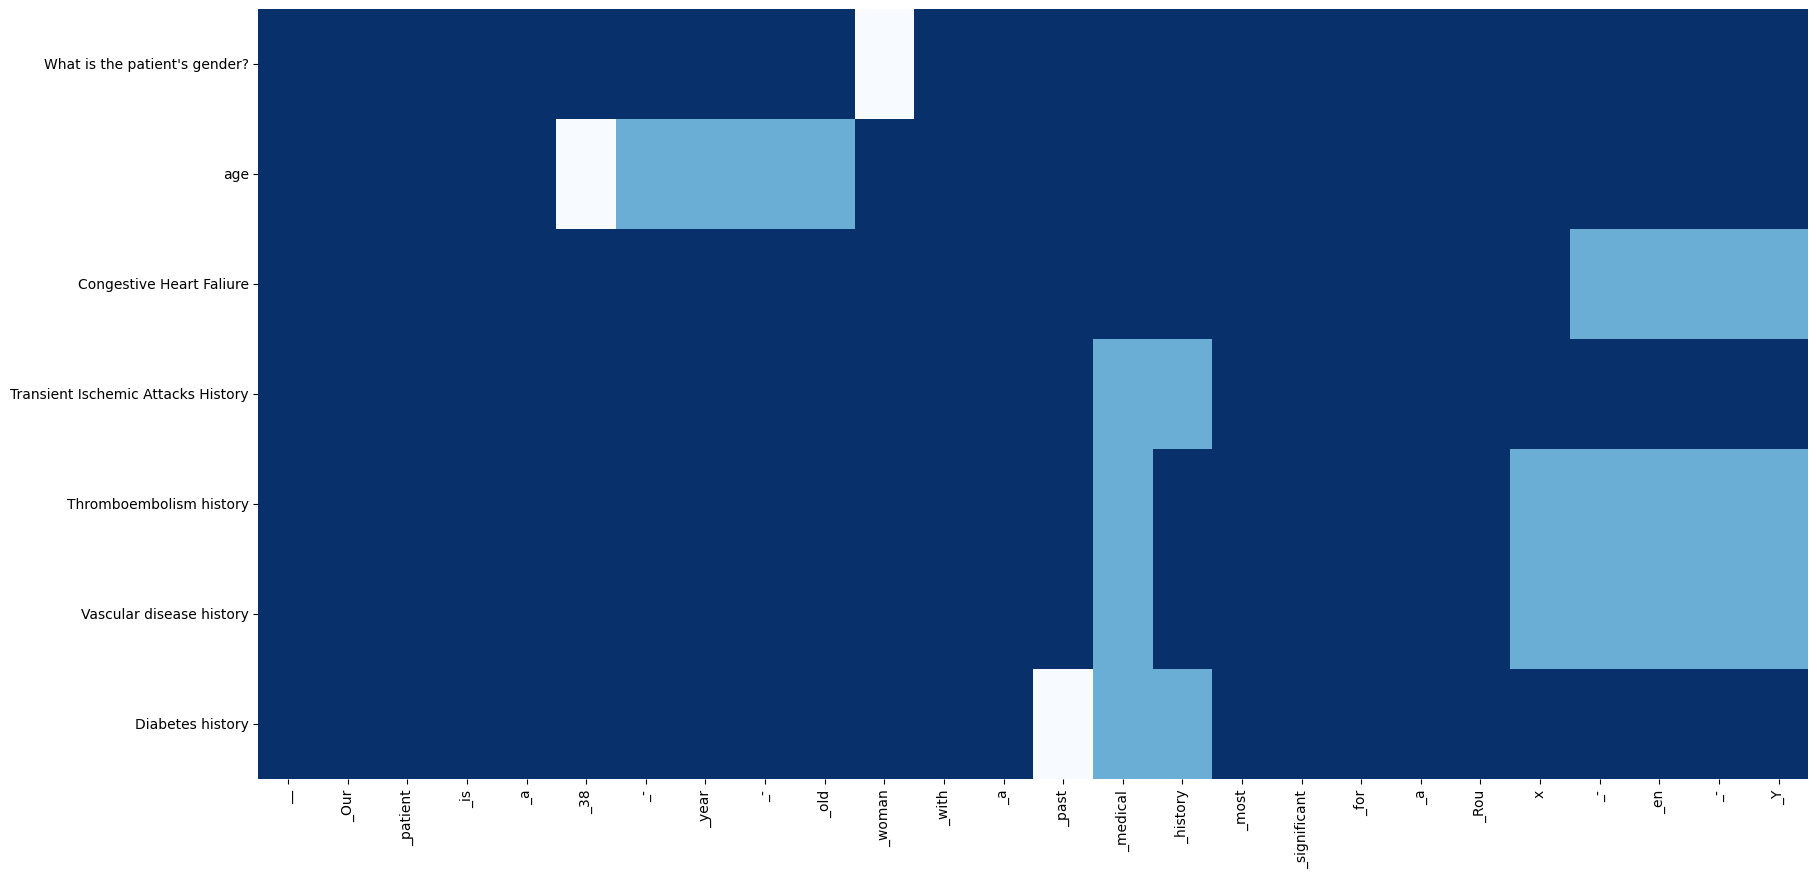

In [9]:
df = pd.DataFrame(tag_predictions_list, columns=tokens, index=questions)
# drop all-zero rows
df = df.loc[(df != 2).any(axis=1)]
plt.figure(figsize=(20, 10))
sns.heatmap(df, cmap="Blues", cbar=False)

### fMRI example

In [ ]:
from neuro.features.questions.gpt4 import QS_35_STABLE
QS_35_STABLE

In [ ]:
text = open('../data/wheretheressmoke_punc.txt').read()

Does the sentence describe a personal reflection or thought? []
Does the sentence contain a proper noun? []
Does the sentence describe a physical action? []
Does the sentence describe a personal or social interaction that leads to a change or revelation? []
Does the sentence involve the mention of a specific object or item? []
Does the sentence involve a description of physical environment or setting? []
Does the sentence describe a relationship between people? []
Does the sentence mention a specific location? ['New York']
Is time mentioned in the input? []
Is the sentence abstract rather than concrete? []
Does the sentence express the narrator's opinion or judgment about an event or character? []
Is the input related to a specific industry or profession? []
Does the sentence include dialogue? ['I reached over and secretly undid my seatbelt']
Does the sentence describe a visual experience or scene? []
Does the input involve planning or organizing? []
Does the sentence involve spatial r

<Axes: >

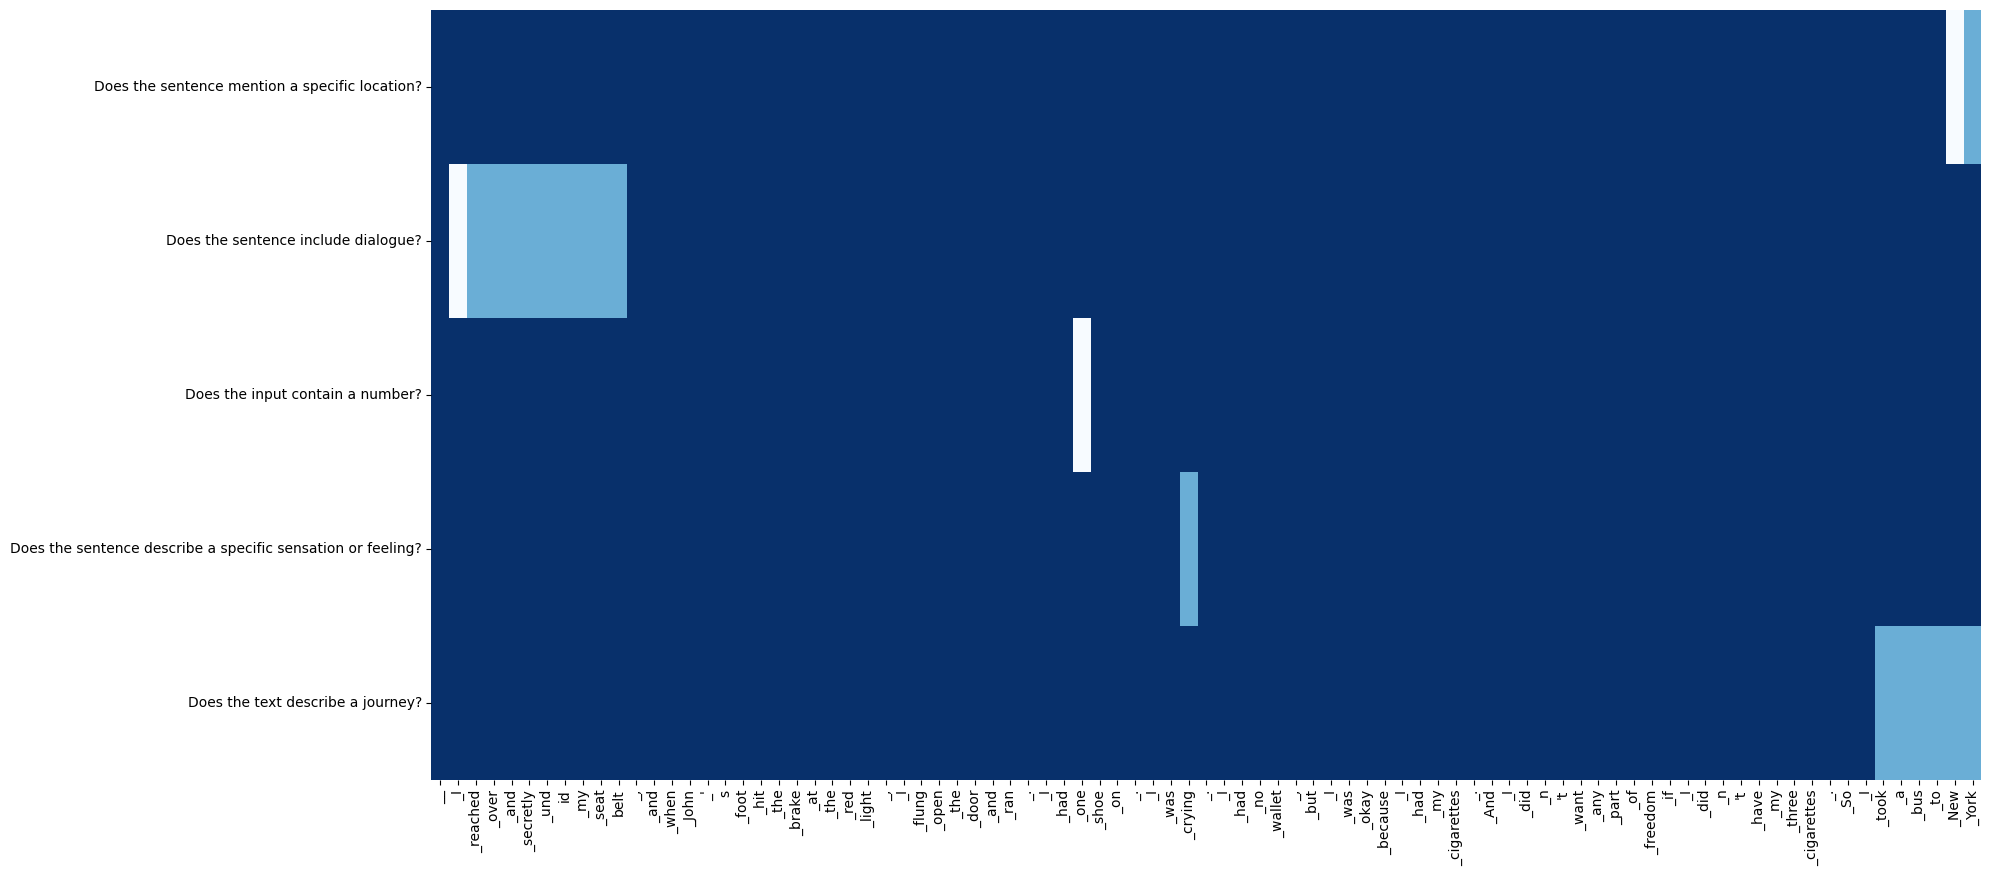

In [ ]:
text = "I reached over and secretly undid my seatbelt, and when John's foot hit the brake at the red light, I flung open the door and ran. I had one shoe on. I was crying. I had no wallet, but I was okay because I had my cigarettes. And I didn't want any part of freedom if I didn't have my three cigarettes. So I took a bus to New York."
# text = text[:50]

tag_predictions_list = []
questions = QS_35_STABLE
# questions = [
#     'What number is mentioned here?',
# 'What proper noun is mentioned here?',
# 'What person is mentioned here?',
#     'What measurment is mentioned here?',
#     'What negation is mentioned here?',
#     'What location is mentioned here?',
# ]
# questions = [
#     "What is the person mentioned here?",
#     "What is the city mentioned here?",
#     "Who goes with Tom together?",
#     "What do Tom and Jack go to Paris for?",
#     "Where does George live in?",
# ]
for question in questions:
    prompt = f"User:\n\n{text}\n\nQuestion: {question}\n\nAssistant:"
    tokens, tag_predictions, predictions = next_tokens_extraction(prompt)
    tokens = [clean_token(token) for token in tokens]
    print(question, predictions)
    tag_predictions_list.append(tag_predictions)

df = pd.DataFrame(tag_predictions_list, columns=tokens, index=questions)
# drop all-zero rows
df = df.loc[(df != 2).any(axis=1)]
plt.figure(figsize=(20, 10))
sns.heatmap(df, cmap="Blues", cbar=False)

# Load gt labels

In [ ]:
join(neuro.config.root_dir, 'qa/cache_gpt')

In [ ]:
!ls /home/chansingh/mntv1/deep-fMRI/qa/cache_gpt

In [ ]:
ngrams = np.array(joblib.load(join(neuro.config.root_dir, 'qa/cache_gpt',
                                   'ngrams_list_total.joblib'))['ngrams_list_total'])

In [ ]:
np.unique([len(x.split()) for x in ngrams], return_counts=True)

In [ ]:
idxs_mask = np.zeros_like(ngrams).astype(bool)
idxs_mask[50:150] = True

In [ ]:
q = 'Does the input contain a number?.pkl'
labs = joblib.load(join(neuro.config.root_dir, 'qa/cache_gpt', q))

In [ ]:
ngrams_story = ngrams[idxs_mask]
labs_story = labs[idxs_mask]

In [ ]:
# convert list of running ngrams back into original text
ngrams_story

words_story = np.array([x.split()[0] for x in ngrams_story])[labs_story]

In [ ]:
' '.join(words_story)

In [ ]:
ngrams_story[labs_story]

In [ ]:
labs_story